# Predicting Price Impact

Here we predict the price impact on trades against the WETH/USDC 0.3% pool on Uniswap v3. We show that a simple OLS regression against trade size gives a very high R^2 value. When using the regression results to predict the amount of token we get out of a trade, we get a very low mean percentage error of <0.01%.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.sim.slippage import analyze

Mean percentage error: 0.004%
Mean percentage error: 0.006%

Coefficients:
[[ 0.00000000e+00 -2.82545974e-09]
 [-3.97739956e-06  0.00000000e+00]]

Intercepts:
[[ 0.         -0.00300451]
 [-0.00301359  0.        ]]

Results:
[[0.         0.91565548]
 [0.86055151 0.        ]]


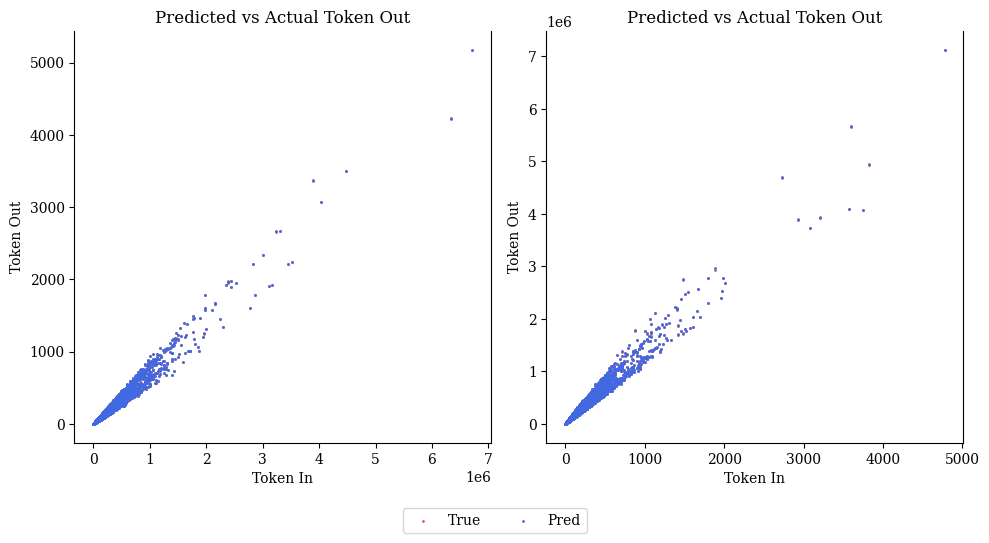

In [8]:
fn = "../data/slippage/eth_usdc_0_3.csv"
decimals = [18, 6]

coefs, intercepts, results = analyze(fn, decimals, plot=True)
print(f"\nCoefficients:\n{coefs}")
print(f"\nIntercepts:\n{intercepts}")
print(f"\nResults:\n{results}")